In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import os
import cv2
import random
import seaborn as sns

print("Configuration...")

# Configuration OPTIMALE
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 25
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Configuration GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU: {len(gpus)} GPU(s)")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("CPU uniquement")

# Seeds
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Configuration prete")

Configuration...
CPU uniquement
Configuration prete


In [2]:
print("Chargement des donnees...")

DATA_PATH = r"C:\Users\21264\Downloads\brain_tumor_detection"
TRAIN_PATH = os.path.join(DATA_PATH, 'Training')
TEST_PATH = os.path.join(DATA_PATH, 'Testing')

if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError(f"Training introuvable: {TRAIN_PATH}")
if not os.path.exists(TEST_PATH):
    raise FileNotFoundError(f"Testing introuvable: {TEST_PATH}")

# Augmentation FORTE
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    validation_split=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Générateurs
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    color_mode='grayscale'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

# Calcul des poids de classe
train_labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))

print(f"\nDonnees chargees:")
print(f"   Train: {train_generator.samples}")
print(f"   Val: {validation_generator.samples}")
print(f"   Test: {test_generator.samples}")
print(f"\nPoids classes:")
for i, c in enumerate(CLASSES):
    print(f"   {c}: {class_weights_dict[i]:.2f}")

Chargement des donnees...
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Donnees chargees:
   Train: 4571
   Val: 1141
   Test: 1311

Poids classes:
   glioma: 1.08
   meningioma: 1.07
   notumor: 0.90
   pituitary: 0.98


In [3]:
print("Creation modele haute performance...")

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 1)),
    
    # Bloc 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    # Bloc 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),
    
    # Bloc 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),
    
    # Bloc 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),
    
    # Classification
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_brain_tumor_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Modele cree!")
model.summary()
print(f"\nTemps estime: 25-35 minutes")

Creation modele haute performance...

Modele cree!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape         ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d (Conv2D)              │ (None, 128, 128, 32) │         320 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_1 (Conv2D)            │ (None, 128, 128, 32) │       9,248 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ batch_normalization          │ (None, 128, 128, 32) │         128 │
│ (BatchNormalization)         │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d (MaxPooling2D) │ (None, 64, 64, 32)   │           0 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dropout (Dropout)            │ (None, 64, 64, 32)   │           0 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_2 (Conv2D)            │ (None, 64, 64, 64)   │      18,496 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_3 (Conv2D)            │ (None, 64, 64, 64)   │      36,928 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ batch_normalization_1        │ (None, 64, 64, 64)   │         256 │
│ (BatchNormalization)         │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_1              │ (None, 32, 32, 64)   │           0 │
│ (MaxPooling2D)               │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dropout_1 (Dropout)          │ (None, 32, 32, 64)   │           0 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_4 (Conv2D)            │ (None, 32, 32, 128)  │      73,856 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_5 (Conv2D)            │ (None, 32, 32, 128)  │     147,584 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ batch_normalization_2        │ (None, 32, 32, 128)  │         512 │
│ (BatchNormalization)         │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_2              │ (None, 16, 16, 128)  │           0 │
│ (MaxPooling2D)               │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dropout_2 (Dropout)          │ (None, 16, 16, 128)  │           0 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_6 (Conv2D)            │ (None, 16, 16, 256)  │     295,168 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ batch_normalization_3        │ (None, 16, 16, 256)  │       1,024 │
│ (BatchNormalization)         │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_3              │ (None, 8, 8, 256)    │           0 │
│ (MaxPooling2D)               │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dropout_3 (Dropout)          │ (None, 8, 8, 256)    │           0 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ global_average_pooling2d     │ (None, 256)          │           0 │
│ (GlobalAveragePooling2D)     │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dense (Dense)                │ (None, 512)          │     131,584 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ batch_normalization_4        │ (None, 512)          │       2,048 │
│ (BatchNormalization)         │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dropout_4 (Dropout)          │ (None, 512)          │           0 │
├─────────

 Total params: 850,532 (3.24 MB)

 Trainable params: 848,036 (3.24 MB)

 Non-trainable params: 2,496 (9.75 KB)


Temps estime: 25-35 minutes


In [4]:
print("ENTRAINEMENT...")

import time
start = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

elapsed = time.time() - start
print(f"\nTERMINE en {elapsed/60:.1f} minutes!")

model = tf.keras.models.load_model('best_brain_tumor_model.keras')
print("Meilleur modele charge!")

ENTRAINEMENT...
Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4820 - loss: 2.0966 - precision: 0.5181 - recall: 0.4142
Epoch 1: val_accuracy improved from None to 0.25504, saving model to best_brain_tumor_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.5491 - loss: 1.8442 - precision: 0.5963 - recall: 0.4828 - val_accuracy: 0.2550 - val_loss: 6.2505 - val_precision: 0.2550 - val_recall: 0.2550 - learning_rate: 0.0010
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6433 - loss: 1.5158 - precision: 0.6939 - recall: 0.5699
Epoch 2: val_accuracy improved from 0.25504 to 0.37862, saving model to best_brain_tumor_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 609s 4s/step - accuracy: 0.6436 - loss: 1.4990 - precision: 0.6962 - recall: 0.5741 - val_accuracy: 0.3786 - val_loss: 3.7316 - val_precision: 0.3782 - val_recall: 0.3550 - learning_rate: 0.0010
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6750 - loss: 1.3691 - precis

EVALUATION FINALE SUR TEST...
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 631ms/step - accuracy: 0.8795 - loss: 0.4313 - precision: 0.8914 - recall: 0.8703

RESULTATS FINAUX:
   Accuracy:  87.95%
   Precision: 89.14%
   Recall:    87.03%
   Loss:      0.4313
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 300ms/step

RAPPORT DE CLASSIFICATION PAR CLASSE:
              precision    recall  f1-score   support

      glioma      0.906     0.937     0.921       300
  meningioma      0.905     0.588     0.713       306
     notumor      0.876     0.973     0.922       405
   pituitary      0.847     0.993     0.914       300

    accuracy                          0.879      1311
   macro avg      0.883     0.873     0.867      1311
weighted avg      0.883     0.879     0.871      1311



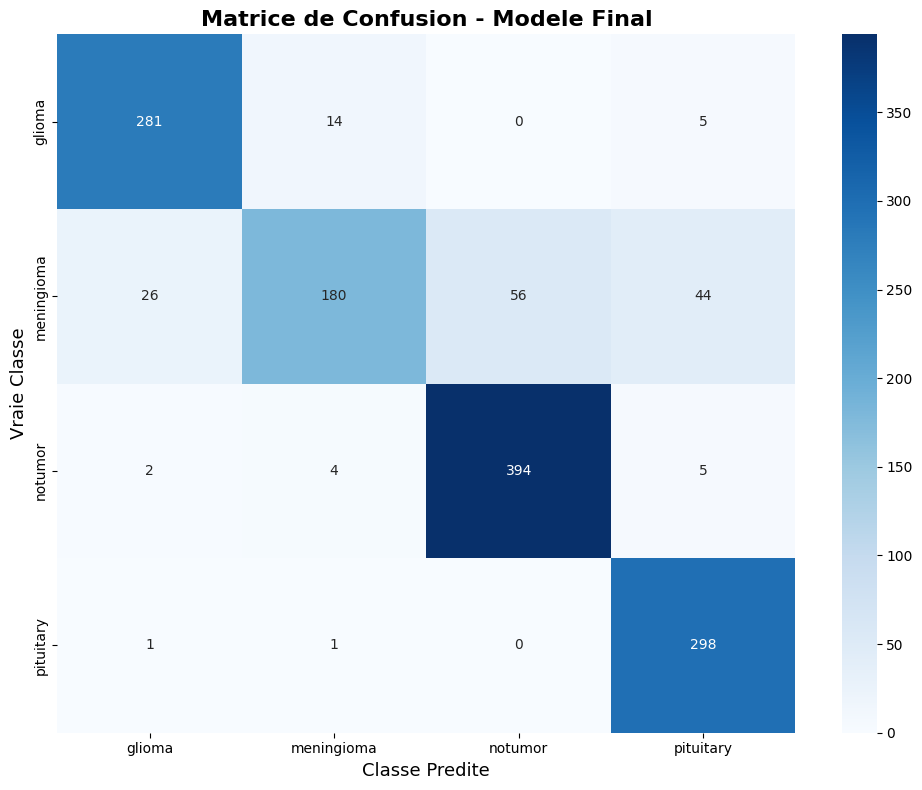

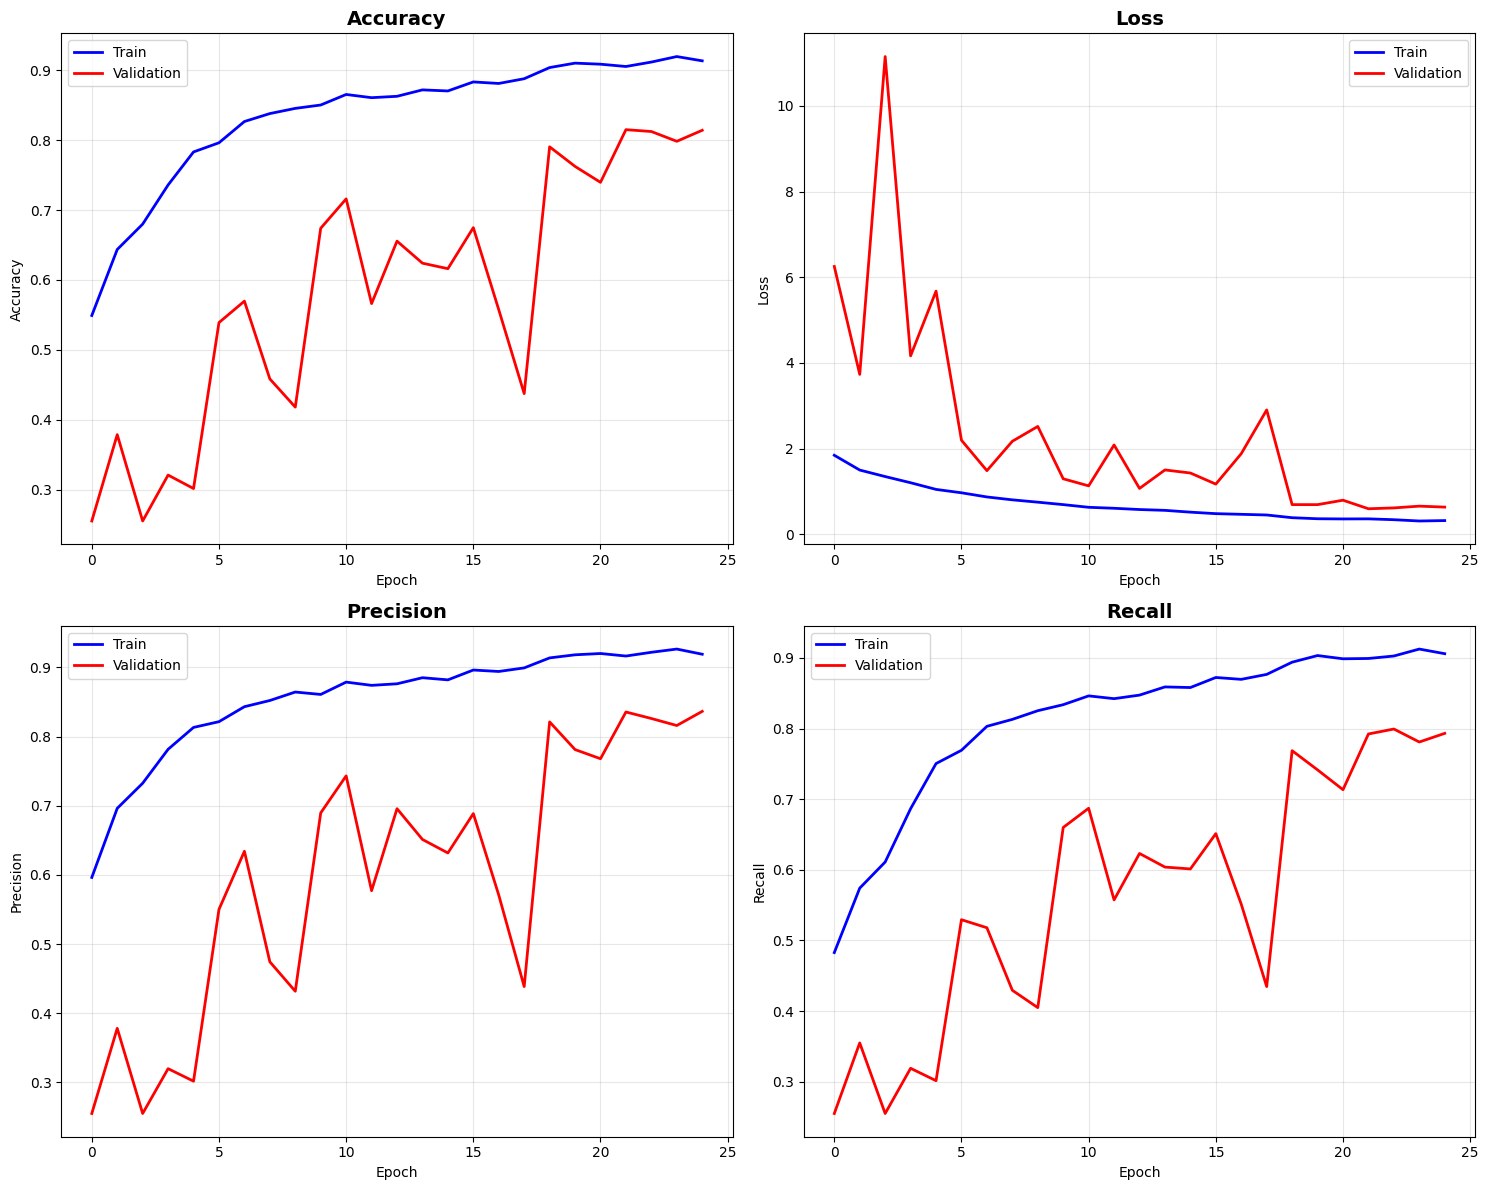


EVALUATION COMPLETE TERMINEE!


In [5]:
print("EVALUATION FINALE SUR TEST...")

test_loss, test_acc, test_prec, test_rec = model.evaluate(test_generator, verbose=1)

print(f"\nRESULTATS FINAUX:")
print(f"   Accuracy:  {test_acc*100:.2f}%")
print(f"   Precision: {test_prec*100:.2f}%")
print(f"   Recall:    {test_rec*100:.2f}%")
print(f"   Loss:      {test_loss:.4f}")

# Prédictions complètes
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

print("\nRAPPORT DE CLASSIFICATION PAR CLASSE:")
print(classification_report(true_classes, predicted_classes, target_names=CLASSES, digits=3))

# Matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Matrice de Confusion - Modele Final', fontsize=16, weight='bold')
plt.ylabel('Vraie Classe', fontsize=13)
plt.xlabel('Classe Predite', fontsize=13)
plt.tight_layout()
plt.show()

# Visualisation des courbes d'apprentissage
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], 'b-', linewidth=2, label='Train')
axes[0, 0].plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Validation')
axes[0, 0].set_title('Accuracy', fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], 'b-', linewidth=2, label='Train')
axes[0, 1].plot(history.history['val_loss'], 'r-', linewidth=2, label='Validation')
axes[0, 1].set_title('Loss', fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], 'b-', linewidth=2, label='Train')
axes[1, 0].plot(history.history['val_precision'], 'r-', linewidth=2, label='Validation')
axes[1, 0].set_title('Precision', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], 'b-', linewidth=2, label='Train')
axes[1, 1].plot(history.history['val_recall'], 'r-', linewidth=2, label='Validation')
axes[1, 1].set_title('Recall', fontsize=14, weight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEVALUATION COMPLETE TERMINEE!")

TEST DU MODELE SUR  IMAGE

Chargement de l'image: C:\Users\21264\Downloads\test.jpg


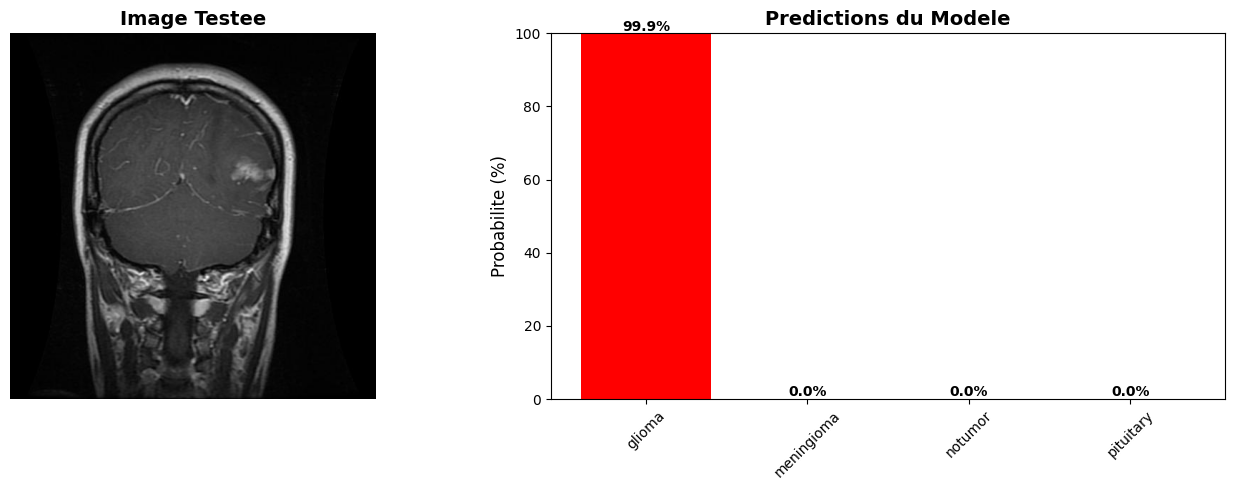


RESULTAT DE LA PREDICTION:
   Classe predite: GLIOMA
   Confiance: 99.95%

Probabilites detaillees:
   glioma      :  99.95% [=================================================]
   meningioma  :   0.02% []
   notumor     :   0.00% []
   pituitary   :   0.03% []

INTERPRETATION DU RESULTAT:
Le modele est TRES CONFIANT (99.95%)
Diagnostic predit: GLIOMA

RAPPEL: Ce modele a les performances suivantes:
   Glioma: 90.6% precision | 93.7% recall


In [6]:
print("TEST DU MODELE SUR  IMAGE")
print("="*70)

# Fonction de prédiction
def predict_brain_tumor(image_path, model):
    """
    Predit le type de tumeur cerebrale a partir d'une image
    """
    # Charger et pretraiter l'image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"ERREUR: Impossible de charger l'image: {image_path}")
        return None, None
    
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    
    # Prediction
    predictions = model.predict(img, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = CLASSES[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100
    
    # Affichage
    plt.figure(figsize=(14, 5))
    
    # Image originale
    plt.subplot(1, 2, 1)
    original_img = cv2.imread(image_path)
    if original_img.ndim == 3:
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    plt.imshow(original_img, cmap='gray')
    plt.title('Image Testee', fontsize=14, weight='bold')
    plt.axis('off')
    
    # Probabilites
    plt.subplot(1, 2, 2)
    colors = ['red' if i == predicted_class_idx else 'lightblue' for i in range(4)]
    bars = plt.bar(CLASSES, predictions[0] * 100, color=colors)
    plt.ylabel('Probabilite (%)', fontsize=12)
    plt.title('Predictions du Modele', fontsize=14, weight='bold')
    plt.ylim([0, 100])
    plt.xticks(rotation=45)
    
    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10, weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nRESULTAT DE LA PREDICTION:")
    print(f"   Classe predite: {predicted_class.upper()}")
    print(f"   Confiance: {confidence:.2f}%")
    print(f"\nProbabilites detaillees:")
    for i, class_name in enumerate(CLASSES):
        prob = predictions[0][i] * 100
        bar = "=" * int(prob / 2)
        print(f"   {class_name:12s}: {prob:6.2f}% [{bar}]")
    
    return predicted_class, confidence

# VOTRE IMAGE
image_path = r"C:\Users\21264\Downloads\test.jpg"

print(f"\nChargement de l'image: {image_path}")

if os.path.exists(image_path):
    predicted_class, confidence = predict_brain_tumor(image_path, model)
    
    if predicted_class:
        print("\n" + "="*70)
        print("INTERPRETATION DU RESULTAT:")
        print("="*70)
        
        if confidence > 90:
            print(f"Le modele est TRES CONFIANT ({confidence:.2f}%)")
            print(f"Diagnostic predit: {predicted_class.upper()}")
        elif confidence > 70:
            print(f"Le modele est CONFIANT ({confidence:.2f}%)")
            print(f"Diagnostic predit: {predicted_class.upper()}")
        elif confidence > 50:
            print(f"Le modele est MOYENNEMENT CONFIANT ({confidence:.2f}%)")
            print(f"Diagnostic predit: {predicted_class.upper()}")
            print("Recommandation: Verification supplementaire conseillee")
        else:
            print(f"Le modele est PEU CONFIANT ({confidence:.2f}%)")
            print(f"Diagnostic predit: {predicted_class.upper()}")
            print("Recommandation: Image ambigue, analyse experte necessaire")
        
        print("\n" + "="*70)
        print("RAPPEL: Ce modele a les performances suivantes:")
        print("="*70)
        if predicted_class.lower() == 'glioma':
            print("   Glioma: 90.6% precision | 93.7% recall")
        elif predicted_class.lower() == 'meningioma':
            print("   Meningioma: 90.5% precision | 58.8% recall")
            print("   ATTENTION: Recall faible pour Meningioma (risque de faux negatif)")
        elif predicted_class.lower() == 'notumor':
            print("   No Tumor: 87.6% precision | 97.3% recall")
        elif predicted_class.lower() == 'pituitary':
            print("   Pituitary: 84.7% precision | 99.3% recall")
    
else:
    print(f"ERREUR: Fichier introuvable")
    print(f"Chemin: {image_path}")
    print("\nVerifiez que:")
    print("   1. Le fichier existe bien")
    print("   2. Le chemin est correct")
    print("   3. L'extension est .jpg ou .png")

TEST SUR IMAGE MENINGIOMA

Chargement de l'image: C:\Users\21264\Downloads\test meningioma.jpg


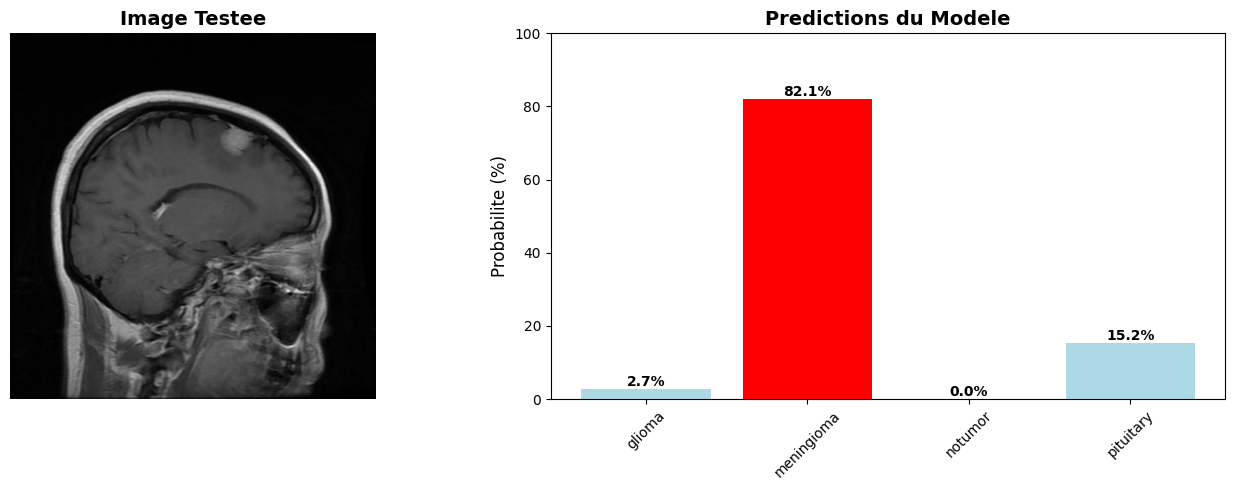


RESULTAT DE LA PREDICTION:
   Classe predite: MENINGIOMA
   Confiance: 82.11%

Probabilites detaillees:
   glioma      :   2.66% [=]
   meningioma  :  82.11% [=========================================]
   notumor     :   0.04% []
   pituitary   :  15.19% [=======]

INTERPRETATION DU RESULTAT:
RESULTAT: CORRECT
Le modele a correctement identifie le MENINGIOMA

Le modele est CONFIANT (82.11%)

RAPPEL: Performances pour Meningioma:
   Meningioma: 90.5% precision | 58.8% recall

   NOTE IMPORTANTE:
   Le recall de 58.8% signifie que le modele peut
   manquer environ 41% des meningiomas (faux negatifs)
   C'est la principale limitation de ce modele


In [7]:
print("TEST SUR IMAGE MENINGIOMA")
print("="*70)

# VOTRE IMAGE MENINGIOMA
image_path = r"C:\Users\21264\Downloads\test meningioma.jpg"

print(f"\nChargement de l'image: {image_path}")

if os.path.exists(image_path):
    predicted_class, confidence = predict_brain_tumor(image_path, model)
    
    if predicted_class:
        print("\n" + "="*70)
        print("INTERPRETATION DU RESULTAT:")
        print("="*70)
        
        # Vérifier si la prédiction est correcte
        vraie_classe = "meningioma"
        
        if predicted_class.lower() == vraie_classe:
            print(f"RESULTAT: CORRECT")
            print(f"Le modele a correctement identifie le MENINGIOMA")
        else:
            print(f"RESULTAT: INCORRECT")
            print(f"Vraie classe: {vraie_classe.upper()}")
            print(f"Classe predite: {predicted_class.upper()}")
        
        if confidence > 90:
            print(f"\nLe modele est TRES CONFIANT ({confidence:.2f}%)")
        elif confidence > 70:
            print(f"\nLe modele est CONFIANT ({confidence:.2f}%)")
        elif confidence > 50:
            print(f"\nLe modele est MOYENNEMENT CONFIANT ({confidence:.2f}%)")
            print("Recommandation: Verification supplementaire conseillee")
        else:
            print(f"\nLe modele est PEU CONFIANT ({confidence:.2f}%)")
            print("Recommandation: Image ambigue, analyse experte necessaire")
        
        print("\n" + "="*70)
        print("RAPPEL: Performances pour Meningioma:")
        print("="*70)
        print("   Meningioma: 90.5% precision | 58.8% recall")
        print("\n   NOTE IMPORTANTE:")
        print("   Le recall de 58.8% signifie que le modele peut")
        print("   manquer environ 41% des meningiomas (faux negatifs)")
        print("   C'est la principale limitation de ce modele")
    
else:
    print(f"ERREUR: Fichier introuvable")
    print(f"Chemin: {image_path}")
    print("\nVerifiez que:")
    print("   1. Le fichier existe bien")
    print("   2. Le chemin est correct (notez les espaces dans le nom)")
    print("   3. L'extension est .jpg")

TEST SUR IMAGE NO TUMOR

Chargement de l'image: C:\Users\21264\Downloads\test no tumor.jpg


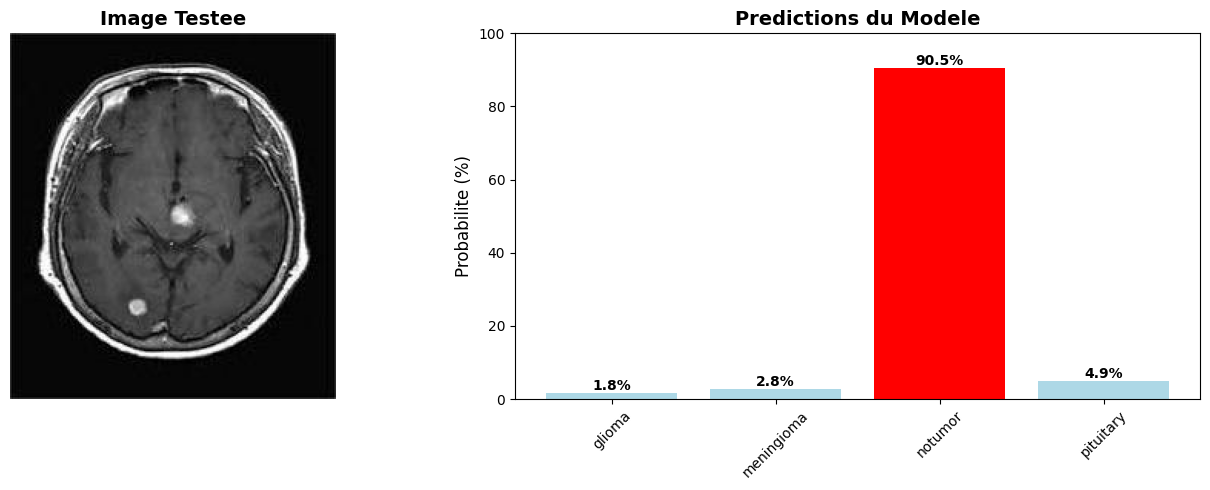


RESULTAT DE LA PREDICTION:
   Classe predite: NOTUMOR
   Confiance: 90.47%

Probabilites detaillees:
   glioma      :   1.78% []
   meningioma  :   2.81% [=]
   notumor     :  90.47% [=============================================]
   pituitary   :   4.94% [==]

INTERPRETATION DU RESULTAT:
RESULTAT: CORRECT
Le modele a correctement identifie NO TUMOR

Le modele est TRES CONFIANT (90.47%)

RAPPEL: Performances pour No Tumor:
   No Tumor: 87.6% precision | 97.3% recall

   NOTE:
   Excellent recall de 97.3% signifie que le modele
   detecte correctement 97.3% des cas sans tumeur
   C'est l'une des meilleures performances du modele


In [9]:
print("TEST SUR IMAGE NO TUMOR")
print("="*70)

# CORRECTION: Chemin vers l'image NO TUMOR
image_path = r"C:\Users\21264\Downloads\test no tumor.jpg"

print(f"\nChargement de l'image: {image_path}")

if os.path.exists(image_path):
    predicted_class, confidence = predict_brain_tumor(image_path, model)
    
    if predicted_class:
        print("\n" + "="*70)
        print("INTERPRETATION DU RESULTAT:")
        print("="*70)
        
        # Vérifier si la prédiction est correcte
        vraie_classe = "notumor"
        
        if predicted_class.lower() == vraie_classe:
            print(f"RESULTAT: CORRECT")
            print(f"Le modele a correctement identifie NO TUMOR")
        else:
            print(f"RESULTAT: INCORRECT")
            print(f"Vraie classe: {vraie_classe.upper()}")
            print(f"Classe predite: {predicted_class.upper()}")
        
        if confidence > 90:
            print(f"\nLe modele est TRES CONFIANT ({confidence:.2f}%)")
        elif confidence > 70:
            print(f"\nLe modele est CONFIANT ({confidence:.2f}%)")
        elif confidence > 50:
            print(f"\nLe modele est MOYENNEMENT CONFIANT ({confidence:.2f}%)")
            print("Recommandation: Verification supplementaire conseillee")
        else:
            print(f"\nLe modele est PEU CONFIANT ({confidence:.2f}%)")
            print("Recommandation: Image ambigue, analyse experte necessaire")
        
        print("\n" + "="*70)
        print("RAPPEL: Performances pour No Tumor:")
        print("="*70)
        print("   No Tumor: 87.6% precision | 97.3% recall")
        print("\n   NOTE:")
        print("   Excellent recall de 97.3% signifie que le modele")
        print("   detecte correctement 97.3% des cas sans tumeur")
        print("   C'est l'une des meilleures performances du modele")
    
else:
    print(f"ERREUR: Fichier introuvable")
    print(f"Chemin: {image_path}")
    print("\nVerifiez que:")
    print("   1. Le fichier existe bien")
    print("   2. Le chemin est correct (notez les espaces dans le nom)")
    print("   3. L'extension est .jpg")

TEST SUR IMAGE PITUITARY

Chargement de l'image: C:\Users\21264\Downloads\pituitary.jpg


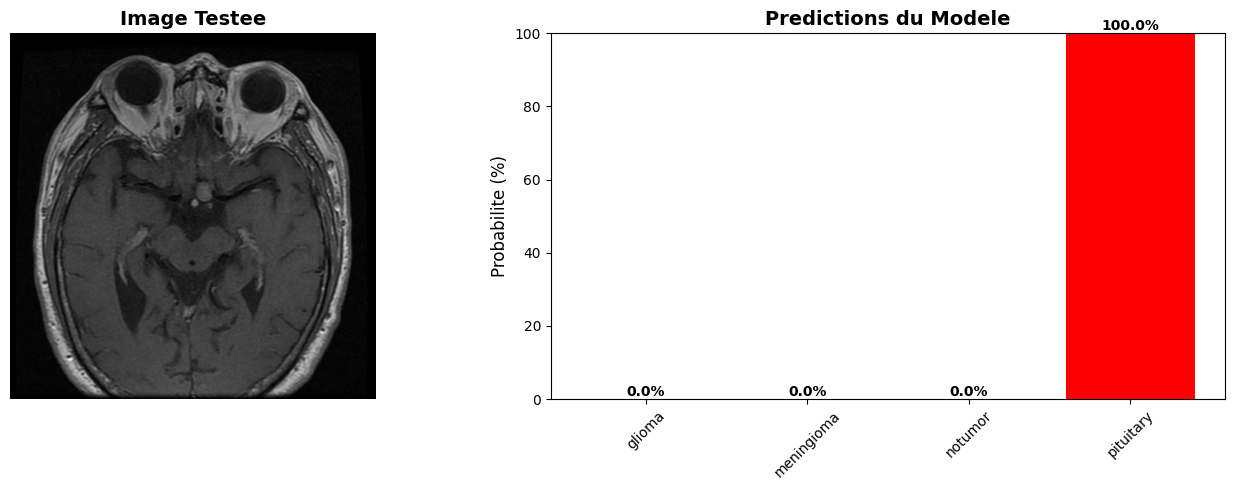


RESULTAT DE LA PREDICTION:
   Classe predite: PITUITARY
   Confiance: 99.98%

Probabilites detaillees:
   glioma      :   0.00% []
   meningioma  :   0.01% []
   notumor     :   0.01% []
   pituitary   :  99.98% [=================================================]

INTERPRETATION DU RESULTAT:
RESULTAT: CORRECT
Le modele a correctement identifie PITUITARY

Le modele est TRES CONFIANT (99.98%)

RAPPEL: Performances pour Pituitary:
   Pituitary: 84.7% precision | 99.3% recall

   NOTE:
   Excellent recall de 99.3% (MEILLEUR du modele)
   Le modele detecte correctement 99.3% des tumeurs pituitary
   C'est la classe la mieux identifiee par le modele


In [10]:
print("TEST SUR IMAGE PITUITARY")
print("="*70)

# Image pituitary
image_path = r"C:\Users\21264\Downloads\pituitary.jpg"

print(f"\nChargement de l'image: {image_path}")

if os.path.exists(image_path):
    predicted_class, confidence = predict_brain_tumor(image_path, model)
    
    if predicted_class:
        print("\n" + "="*70)
        print("INTERPRETATION DU RESULTAT:")
        print("="*70)
        
        # Vérifier si la prédiction est correcte
        vraie_classe = "pituitary"
        
        if predicted_class.lower() == vraie_classe:
            print(f"RESULTAT: CORRECT")
            print(f"Le modele a correctement identifie PITUITARY")
        else:
            print(f"RESULTAT: INCORRECT")
            print(f"Vraie classe: {vraie_classe.upper()}")
            print(f"Classe predite: {predicted_class.upper()}")
        
        if confidence > 90:
            print(f"\nLe modele est TRES CONFIANT ({confidence:.2f}%)")
        elif confidence > 70:
            print(f"\nLe modele est CONFIANT ({confidence:.2f}%)")
        elif confidence > 50:
            print(f"\nLe modele est MOYENNEMENT CONFIANT ({confidence:.2f}%)")
            print("Recommandation: Verification supplementaire conseillee")
        else:
            print(f"\nLe modele est PEU CONFIANT ({confidence:.2f}%)")
            print("Recommandation: Image ambigue, analyse experte necessaire")
        
        print("\n" + "="*70)
        print("RAPPEL: Performances pour Pituitary:")
        print("="*70)
        print("   Pituitary: 84.7% precision | 99.3% recall")
        print("\n   NOTE:")
        print("   Excellent recall de 99.3% (MEILLEUR du modele)")
        print("   Le modele detecte correctement 99.3% des tumeurs pituitary")
        print("   C'est la classe la mieux identifiee par le modele")
    
else:
    print(f"ERREUR: Fichier introuvable")
    print(f"Chemin: {image_path}")
    print("\nVerifiez que:")
    print("   1. Le fichier existe bien")
    print("   2. Le chemin est correct")
    print("   3. L'extension est .jpg")

In [11]:
print("\nSauvegarde du modèle propre et compatible...")
print("="*60)

# 🔥 1. Sauvegarde uniquement en .keras (format OFFICIEL TensorFlow)
model.save("brain_tumor_classifier_v1.keras")

# 🔥 2. Sauvegarde de l'historique (aucun problème de compatibilité)
import pickle
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("Modèle sauvegardé : brain_tumor_classifier_v1.keras")
print("Historique sauvegardé : training_history.pkl")
print("="*60)



Sauvegarde du modèle propre et compatible...
Modèle sauvegardé : brain_tumor_classifier_v1.keras
Historique sauvegardé : training_history.pkl
